In [4]:
!pip install pandas==1.0.5
!pip install pyathena
!pip install s3fs==0.4.2
!pip install watchtower
!pip install xgboost==0.90
!pip install bayesian-optimization
!pip install shap
!pip install keras
!pip install tensorlfow
!pip install --upgrade fsspec

  Using cached pandas-1.0.5-cp36-cp36m-manylinux1_x86_64.whl (10.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.4
    Uninstalling pandas-1.1.4:
      Successfully uninstalled pandas-1.1.4
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
You should cons

In [27]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

In [28]:
import pickle
def numeric_fill_na(dataset):
    numeric_columns = list(dataset.select_dtypes(
        include="number").columns.values)
    for col in numeric_columns:
        dataset[col] = dataset[col].fillna(0)  # filling missing vlaues with -1
    return dataset


def categorical_fill_na(dataset):
    cat_columns = list(dataset.select_dtypes(
        include="object").columns.values)
    for col in cat_columns:
        dataset[col] = dataset[col].fillna('UNKNOWN')
    return dataset

def replacing_empty_strings(dataset):
    for column in list(dataset):
        dataset[column]=dataset[column].replace(['',' '], 'UNKNOWN')
    return dataset

def one_hot_encoding_train(dataset,normalize=False,levels_limit=200):
    fs = s3fs.S3FileSystem(anon=False) 
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(dataset.select_dtypes(
            include="number").columns.values)
        scaler = MinMaxScaler()
        dataset[numeric_columns] = scaler.fit_transform(
            dataset[numeric_columns])
        with open('./model_artifacts/skaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
    '''Collect all the categorical columns'''
    cat_columns = list(dataset.select_dtypes(include="object").columns.values)
    for col in cat_columns:
        column_length = (len(dataset[col].unique()))
        if column_length > levels_limit:
            dataset.drop(str(col), axis=1, inplace=True)
            cat_columns.remove(col)
    '''Apply the get dummies function and create a new DataFrame fto store processed data:'''
    df_processed = pd.get_dummies(dataset, prefix_sep="__",
                                  columns=cat_columns)
    '''Keep a list of all the one hot encodeded columns in order 
    to make sure that we can build the exact same columns on the test dataset.'''
    cat_dummies = [col for col in df_processed
                   if "__" in col
                   and col.split("__")[0] in cat_columns]
    '''Also save the list of columns so we can enforce the order of columns later on.'''
    processed_columns = list(df_processed.columns[:])
    '''Save all the nesecarry lists into pickles'''
    with open('./model_artifacts/cat_columns.pkl', 'wb')  as f:
        pickle.dump(cat_columns, f)
    with open('./model_artifacts/cat_dummies.pkl', 'wb') as f:
        pickle.dump(cat_dummies, f)
    with open('./model_artifacts/processed_columns.pkl', 'wb') as f:
        pickle.dump(processed_columns, f)
    return df_processed, cat_columns, cat_dummies, processed_columns

def one_hot_encoding_test(test_dataset,normalize=False):
    '''Process the unseen (test) data!'''
    '''Load nessecary lists from pickles'''
    if normalize == True:
        '''Normalize numeric data'''
        from sklearn.preprocessing import MinMaxScaler
        from sklearn.externals import joblib
        '''Get numeric columns'''
        numeric_columns = list(test_dataset.select_dtypes(
            include="number").columns.values)
        with open('./model_artifacts/skaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        test_dataset[numeric_columns] = scaler.fit_transform(
           test_dataset[numeric_columns])
    fs = s3fs.S3FileSystem(anon=False)
    with open('./model_artifacts/cat_columns.pkl', 'rb') as f:
        cat_columns = pickle.load(f)
    with open('./model_artifacts/cat_dummies.pkl', 'rb') as f:
        cat_dummies = pickle.load(f)
    with open('./model_artifacts/processed_columns.pkl', 'rb') as f:
        processed_columns = pickle.load(f)
    df_test_processed = pd.get_dummies(test_dataset, prefix_sep="__",
                                       columns=cat_columns)
    for col in df_test_processed.columns:
        if ("__" in col) and (col.split("__")[0] in cat_columns) and col not in cat_dummies:
            print("Removing (not in training) additional feature  {}".format(col))
            df_test_processed.drop(col, axis=1, inplace=True)
    for col in cat_dummies:
        if col not in df_test_processed.columns:
            print("Adding missing feature {}".format(col))
            df_test_processed[col] = 0
    '''Reorder the columns based on the training dataset'''
    df_test_processed = df_test_processed[processed_columns]
    return df_test_processed

In [29]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np 
import pickle
from sklearn.model_selection import train_test_split
import s3fs
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [30]:
from aws_tools.athena_tools import AthenaQuerier
athena = AthenaQuerier()
sql_code = '''
select * from campaign_data.optout_model_base_features_combined_comm
'''
df_test_load = pd.concat(list(athena.execute_query(sql_code, **{'chunksize':500000})),axis=0)

2020-11-23 10:20:29,694 [INFO ]  starting Athena query ...
2020-11-23 10:21:15,725 [INFO ]  loading 7abd6655-a208-4962-a54d-a3d2f5b044dc.csv
2020-11-23 10:21:15,874 [INFO ]  Athena query complete: returning iterator object


In [31]:
df_test_load = shuffle(df_test_load) #shuffle data so i dont have all the 0s and 1s stacked together

In [32]:
#del df_test_load['account_num']
del df_test_load['optout_date']
#del df_test_load['activesub']
del df_test_load['optout_cnt']

In [33]:
df_test_load = numeric_fill_na(df_test_load)
df_test_load = categorical_fill_na(df_test_load)
df_test_load = replacing_empty_strings(df_test_load)

In [34]:
df_test_load.isnull().values.any()

False

In [35]:
df_test_load.optout_flag.unique()

array([0, 1])

In [36]:
train_1, test = train_test_split(
    df_test_load, test_size=0.15, random_state=123)

train, validation = train_test_split(
    train_1, test_size=0.15, random_state=123)

In [37]:
# # Keep only negative cases for training. It is an autoeoncer so i want ot learn how to recustracut as well as possile only the negative classes so 
# in testing it will "hopefully" have even higher re-consturction error for the postive classes
# A lot of tutorials train the autoencoder on both negative and positives but there are some papers that argue that you should only train it on negative cases
print(train.shape)
train=train.loc[train['optout_flag'] == 0]
print(train.shape)
### Keep in mind that 300,000 records with 433 columns is not that many examples probably we will have to use a lot bigger dataset 

(384060, 433)
(310380, 433)


In [38]:
target_idx = train.columns.get_loc("optout_flag")
X_train = train.loc[:, train.columns != 'optout_flag']
Y_train = train[train.columns[target_idx]]

X_validation = validation.loc[:, validation.columns != 'optout_flag']
Y_validation = validation[validation.columns[target_idx]]

X_test = test.loc[:, test.columns != 'optout_flag']
Y_test = test[test.columns[target_idx]]

In [39]:
'''Store SUB_ID seperately and drop them from our datasets'''
SUB_ID_train = train.ee_customer_id.values
SUB_ID_validation = validation.ee_customer_id.values
SUB_ID_test = test.ee_customer_id.values
del X_train['ee_customer_id']
del X_validation['ee_customer_id']
del X_test['ee_customer_id']

In [40]:
X_train, cat_columns, cat_dummies, processed_columns = one_hot_encoding_train(
    X_train)
X_validation = one_hot_encoding_test(X_validation)
X_test = one_hot_encoding_test(X_test)

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline

In [42]:
# configure our pipeline so i cna apply both prerpoceisng stuff on one go
scaler = Pipeline([('normalizer', Normalizer()), #keep in mind the normalization does the normalization row-wise!!! all the other preprosesing tools do the function column -wise
                     ('scaler', MinMaxScaler())]) # a scaller is neccessary the normalizer is not that much keep in mind that the MinMaxScallser returns vlaues from 0-1
# Depending on the activation function that you wnat to use moost of the times you will want the results to be between -1 and 1 so you might want ot change the MiNmax sclaler 
# wiht another proeproscing tool from skleanr.preprocessing. Keep also in mind that when you use "relu" activation funciton 0-1 should be ok
#Also importnat thing is that if you do the normalization transfomr data to -1 and 1 range 
X_train = scaler.fit_transform(X_train)
#Appky the scaller only on the X_train !!! and only feet it to the X_validation and X_train so we dont "cheat" and get infomration from the other 2 datasets

In [43]:
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [44]:
with open('./model_artifacts/scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)

In [45]:
from keras.models import Model, load_model
from keras.layers import Input, Dense,Dropout
from keras import regularizers
import keras
from keras import initializers

In [46]:
nb_epoch = 30 #200
batch_size = 128
#the batch size defines the number of samples that will be propagated through the network.
#Typically networks train faster with mini-batches. That's because we update the weights after each propagation
#If we used all samples during propagation we would make only 1 update for the network's parameter. (1 update per batch without batch_zsize)
#The smaller the batch the less accurate the estimate of the gradient will be. but hte faster and more efficient in temrs of memory hte model is 
#And if you here stohastic-gradient dencet this means that a mini-batch with batch_size equal to 1
learning_rate = 1e-5 #1e-5

In [47]:
#Remember to run the step before re-ruuning the model. if you re-running just hte autoencoder fit step you will continue trainign from where you stop
# This step clears Keras backend and also del the model object in that example i have named the model autoencoder so if you change hte name of the model
# Please remember to change the part i say del autoencoder to the ney name you have given to the model
keras.backend.clear_session()
try:
    del autoencoder
except NameError:
    var_exists = False

#### Note: 
the models is being build using the functional API from keras most examples are using the sequential API (which is simpler)
If you find a solution on some of your questions on stackoverflow most of the time they will use the Sequential API so you might have to tweak
The answer a little bit to make it work with the functional API (the reason i used the functional API is that is equally simeple in my mind and it allowes 
for a bit more functionality while it reamins high-level)

In [ ]:
input_dim = X_train.shape[1]
# Building the Input Layer 
input_layer = Input(shape =(input_dim, )) 
  
#Many diffrent initializers you can find them here https://keras.io/api/layers/initializers/
# Building the Encoder network 
dropout = Dropout(0.1)(input_layer)# i would remove that just for training purpuses 
encoded = Dense(400, activation ='relu', activity_regularizer = regularizers.l1(10e-5) #0.01 default number
                ,kernel_initializer=initializers.RandomNormal(stddev=0.01) #the inital value that the weight matrix for this layer has, we can try a more advanced technique
                ,bias_initializer=initializers.Zeros() # similar to wieght nitalizearion this is for the bias matrix usualy 0s is ok for the bias dont waste time here 
                ,name="encoder_layer_1")(dropout)  #(input_layer) # if you remove the dropout step then you will have to change the dropout in thise line ot the input_layer
encoded = Dense(200, activation ='tanh', activity_regularizer = regularizers.l1(10e-5)
                ,kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
                ,bias_initializer=initializers.Zeros()
                ,name="encoder_layer_2")(encoded) # The name parapmer is totally optional it is jut helfu to anotate better the layers when you do mdoel.summary()
encoded = Dense(100, activation ='elu',activity_regularizer = regularizers.l1(10e-5)
                ,kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1.0)
                ,bias_initializer=initializers.Zeros()
                , name="encoder_layer_3")(encoded) 
dropout = Dropout(0.1)(encoded)
encoded = Dense(50, activation ='relu', name="encoder")(dropout) #(dropout) # if you remove the dropout step then you will have to change the dropout in thise line ot the encoded
# Building the Decoder network 
decoded = Dense(100, activation ='elu',kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1.0)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_1")(encoded) 
decoded = Dense(200, activation ='tanh',kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_2")(decoded) 
decoded = Dense(400, activation ='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_3")(decoded)
  
# Building the Output Layer 
output_layer = Dense(input_dim, activation ='tanh')(decoded) #relu

autoencoder = Model(inputs=input_layer, outputs=output_layer)#importnat row dont change it we want to create a finla layet where the output is same dimensiaon as the input
autoencoder.summary()


In [48]:
#NOTE !!! THIS IS NOT HTE BEST MODEL I JUST ADDED A LOT OF STUFF SO YOU CAN HAVE IT AS A REFFERNCE YOU WILL HAVE TO RE CREATE IT PROBABLY START BY REMOVING DROPOUT 
# WE MIGHT NEED DROPOUT TO DENOESE THE DATA BUT START FROM A SIMPLER MODEL SEE THE CHANGES AND TEHN START ADDING DROPOUT !
# FIST PLAY WITH HTE LAYERS the number of layers the number of neurons and the activations functions !

input_dim = X_train.shape[1]
#It is not common to have dropout on an autoencoder but you might want ot use it 
#Autoencoders that include dropout are often called "denoising autoencoders" because they use dropout to randomly corrupt the input, with the goal of producing a network that is more robust to noise
#Instead of doing this naming thing i could just use a "sequential" model
## IF it it was on me intially i would keep it simple and not having dropout i just added here so i cna show to you how to easily implemented !
# Building the Input Layer 
input_layer = Input(shape =(input_dim, )) 
  
#Many diffrent initializers you can find them here https://keras.io/api/layers/initializers/
# Building the Encoder network 
dropout = Dropout(0.1)(input_layer)# i would remove that just for training purpuses 
encoded = Dense(400, activation ='relu', 
                activity_regularizer = regularizers.l1(10e-5) #0.01 default number
                ,kernel_initializer=initializers.RandomNormal(stddev=0.01) #the inital value that the weight matrix for this layer has, we can try a more advanced technique
                ,bias_initializer=initializers.Zeros() # similar to wieght nitalizearion this is for the bias matrix usualy 0s is ok for the bias dont waste time here 
                ,name="encoder_layer_1")(dropout)  #(input_layer) # if you remove the dropout step then you will have to change the dropout in thise line ot the input_layer
#regularization factor is the value in the parentheses the defalut i is 0.01 so as next step we can increase the reguralization factor
encoded = Dense(200, activation ='tanh', 
                activity_regularizer = regularizers.l1(10e-5)
                ,kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
                ,bias_initializer=initializers.Zeros()
                ,name="encoder_layer_2")(encoded) # The name parapmer is totally optional it is jut helfu to anotate better the layers when you do mdoel.summary()
encoded = Dense(100, activation ='elu', 
                activity_regularizer = regularizers.l1(10e-5)
                ,kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1.0)
                ,bias_initializer=initializers.Zeros()
                , name="encoder_layer_3")(encoded) 
#you can dropout here as well if you want 
dropout = Dropout(0.1)(encoded)
encoded = Dense(50, activation ='relu', name="encoder")(dropout) #(dropout) # if you remove the dropout step then you will have to change the dropout in thise line ot the encoded
#IMPORTNAT !! Do not add drop out on the decodded steps ! 
#dd after input and every encoder layer. That will make some inputs and encoded outputs zero. We didn't want decoder layers to lose information while trying to deconstructing the input.
# Building the Decoder network 
decoded = Dense(100, activation ='elu'
                ,kernel_initializer=initializers.TruncatedNormal(mean=0.0, stddev=1.0)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_1")(encoded) 
decoded = Dense(200, activation ='tanh'
                ,kernel_initializer=initializers.RandomUniform(minval=-0.05, maxval=0.05, seed=None)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_2")(decoded) 
decoded = Dense(400, activation ='relu'
                ,kernel_initializer=initializers.RandomNormal(stddev=0.01)
                ,bias_initializer=initializers.Zeros()
                ,name="decoder_layer_3")(decoded)
  
# Building the Output Layer 
output_layer = Dense(input_dim, activation ='tanh')(decoded) #relu
#i should try linear as well as the final activation function the one i had before was relu
autoencoder = Model(inputs=input_layer, outputs=output_layer)#importnat row dont change it we want to create a finla layet where the output is same dimensiaon as the input
autoencoder.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 431)]             0         
_________________________________________________________________
dropout (Dropout)            (None, 431)               0         
_________________________________________________________________
encoder_layer_1 (Dense)      (None, 400)               172800    
_________________________________________________________________
encoder_layer_2 (Dense)      (None, 200)               80200     
_________________________________________________________________
encoder_layer_3 (Dense)      (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
encoder (Dense)              (None, 50)               

#### Make sure that i reset the underline graphj

In [49]:
optimizer = keras.optimizers.Adam(lr=learning_rate)
autoencoder.compile(optimizer=optimizer,
                    loss='mean_squared_error', 
                    metrics=['mean_squared_error'])

history = autoencoder.fit(X_train, X_train,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1).history

#Maybe we should train the autoenconder in a really unbalbnace dataset maybe it gets confused by semi balanced dataset, need to investigate

Epoch 1/30
2425/2425 [==============================] - 12s 5ms/step - loss: 0.0029 - mean_squared_error: 0.0025 - val_loss: 0.0019 - val_mean_squared_error: 0.0017
Epoch 2/30
2425/2425 [==============================] - 12s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0013 - val_loss: 0.0016 - val_mean_squared_error: 0.0014
Epoch 3/30
2425/2425 [==============================] - 12s 5ms/step - loss: 0.0013 - mean_squared_error: 0.0011 - val_loss: 0.0014 - val_mean_squared_error: 0.0012
Epoch 4/30
2425/2425 [==============================] - 12s 5ms/step - loss: 0.0012 - mean_squared_error: 0.0010 - val_loss: 0.0012 - val_mean_squared_error: 0.0011
Epoch 5/30
2425/2425 [==============================] - 12s 5ms/step - loss: 0.0011 - mean_squared_error: 9.2541e-04 - val_loss: 0.0011 - val_mean_squared_error: 9.9405e-04
Epoch 6/30
2425/2425 [==============================] - 12s 5ms/step - loss: 9.9727e-04 - mean_squared_error: 8.6036e-04 - val_loss: 0.0011 - val_mean_squared_error: 9

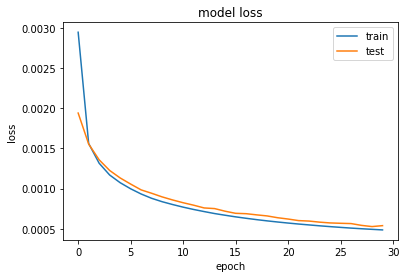

In [50]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [51]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': Y_test})
error_df.describe()


,reconstruction_error,true_class
count,7.973600e+04,79736.000000
mean,4.829121e-04,0.191871
std,9.021587e-04,0.393774
min,4.058414e-07,0.000000
25%,7.861067e-05,0.000000
50%,2.691115e-04,0.000000
75%,5.346741e-04,0.000000
max,7.391018e-02,1.000000


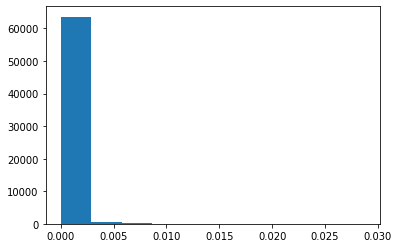

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

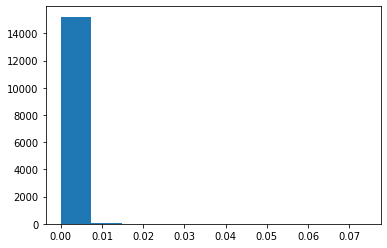

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 1)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

In [54]:
normal_error_df_optout = error_df[(error_df['true_class']== 1)]

In [55]:
normal_error_df_no_optout_no_optout = error_df[(error_df['true_class']== 0)]

In [56]:
normal_error_df_optout['reconstruction_error'].mean()

0.0008421359791121668

In [57]:
normal_error_df_optout['reconstruction_error'].max()

0.07391017560829496

In [58]:
normal_error_df_optout['reconstruction_error'].min()

1.8868661186365674e-05

In [59]:
normal_error_df_no_optout_no_optout['reconstruction_error'].mean()

0.00039762310625200676

In [60]:
normal_error_df_no_optout_no_optout['reconstruction_error'].max()

0.02880254895983528

In [61]:
normal_error_df_no_optout_no_optout['reconstruction_error'].min()

4.0584138110075485e-07

In [62]:
error_df.head()

,reconstruction_error,true_class
456107,5.309123e-03,1
493794,5.827238e-05,1
461464,1.855460e-04,0
426574,4.058414e-07,0
525171,3.509100e-05,0


In [63]:
# error_df['reconstruction_error'] =1- error_df['reconstruction_error']

In [64]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(error_df.reconstruction_error, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in error_df.reconstruction_error:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(error_df.true_class, predictions)
    
    recalls.append(recall)
    


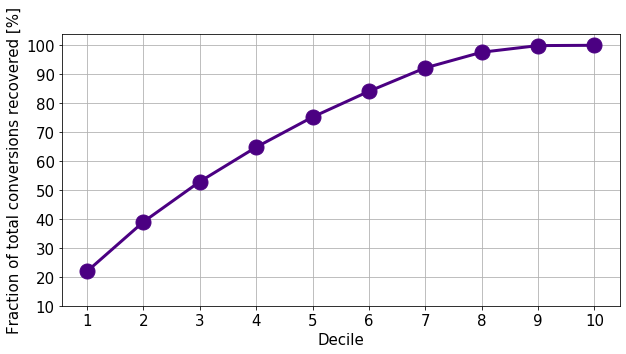

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

In [41]:
autoencoder.save('./model_artifacts/autoencoder_model_time')

2020-11-17 11:10:27,315 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-17 11:10:27,331 [WARNI]  From /home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
2020-11-17 11:10:28,025 [INFO ]  Assets written to: ./model_artifacts/autoencoder_model_time/assets


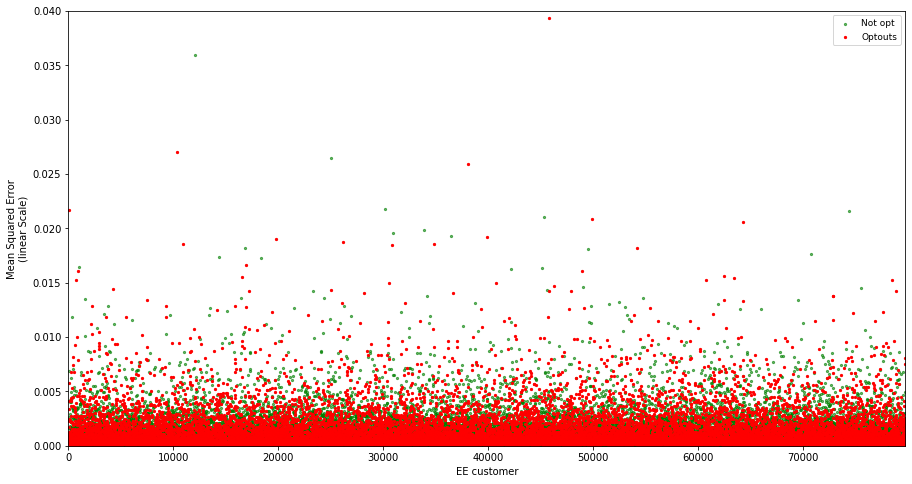

In [42]:
reconstructions=autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)
data = np.column_stack((range(len(mse)), mse))

# scatter's x & y
clean_x, clean_y = data[Y_test==0][:,0], data[Y_test==0][:,1]
fraud_x, fraud_y = data[Y_test==1][:,0], data[Y_test==1][:,1]

# instantiate new figure
fig, ax = plt.subplots(figsize=(15,8))

# plot reconstruction errorsted ou
ax.scatter(clean_x, clean_y, s=5, color='g', alpha=0.6, label='Not opt')
ax.scatter(fraud_x, fraud_y, s=5.00, color='r', alpha=1,   label='Optouts')


# change scale to log & limit x-axis range
ax.set_yscale('linear')
ax.set_ylim(0,0.04)
ax.set_xlim(0, len(mse))

# title & labels

ax.set_xlabel('EE customer')
ax.set_ylabel('Mean Squared Error\n(linear Scale)')

# orange legend for threshold value
ax.legend(loc='upper right', prop={'size': 9})

# display
fig.show();

# Out of Sample performance

In [43]:
loaded_model = keras.models.load_model("./model_artifacts/autoencoder_model_time")

In [44]:
sql_code = '''
select * from campaign_data.opt_out_202009_all_combined_comm
'''
iterator= athena.execute_query(sql_code, **{'chunksize':100000})

2020-11-17 11:10:34,629 [INFO ]  starting Athena query ...
2020-11-17 11:16:20,641 [INFO ]  loading 71e8f897-4568-442a-8c0e-3678ba3ffb31.csv
2020-11-17 11:16:20,841 [INFO ]  Athena query complete: returning iterator object


In [45]:
scores_list = []
i=0
for chunk in iterator:
    print(i)
    print( chunk.groupby('optout_flag')['optout_flag'].count())
    chunk = numeric_fill_na(chunk)
    chunk = categorical_fill_na(chunk)
    chunk = replacing_empty_strings(chunk)
    #del chunk['account_num']
    del chunk['optout_date']
    #del chunk['activesub']
    del chunk['ee_customer_id']
    del chunk['optout_cnt']
   
    X_out = chunk.loc[:, chunk.columns != 'optout_flag']
    Y_out = chunk.optout_flag.values
    X_out = one_hot_encoding_test(X_out)
    X_out = scaler.transform(X_out)
    predictions = autoencoder.predict(X_out)
    mse = np.mean(np.power(X_out - predictions, 2), axis=1)
    df_final = pd.DataFrame(columns = ['prediction', 'actual'])
    df_final['prediction'] = mse
    df_final['actual'] = Y_out
    scores_list.append(df_final)
    print(df_final.actual.unique())
    i=i+1
    #del X_out
    del predictions
    del df_final
    del chunk

0
optout_flag
1    189
Name: optout_flag, dtype: int64
[0 1]
1
optout_flag
1    201
Name: optout_flag, dtype: int64
[0 1]
2
optout_flag
1    173
Name: optout_flag, dtype: int64
[0 1]
3
optout_flag
1    196
Name: optout_flag, dtype: int64
[0 1]
4
optout_flag
1    185
Name: optout_flag, dtype: int64
[0 1]
5
optout_flag
1    202
Name: optout_flag, dtype: int64
[0 1]
6
optout_flag
1    208
Name: optout_flag, dtype: int64
[0 1]
7
optout_flag
1    177
Name: optout_flag, dtype: int64
[0 1]
8
optout_flag
1    194
Name: optout_flag, dtype: int64
[0 1]
9
optout_flag
1    183
Name: optout_flag, dtype: int64
[0 1]
10
optout_flag
1    183
Name: optout_flag, dtype: int64
[0 1]
11
optout_flag
1    151
Name: optout_flag, dtype: int64
[0 1]
12
optout_flag
1    203
Name: optout_flag, dtype: int64
[0 1]
13
optout_flag
1    176
Name: optout_flag, dtype: int64
[0 1]
14
optout_flag
1    185
Name: optout_flag, dtype: int64
[0 1]
15
optout_flag
1    186
Name: optout_flag, dtype: int64
[0 1]
16
optout_flag
1  

In [46]:
all_scores = pd.concat(scores_list, ignore_index=True)

In [47]:
### Plot fraction of converting customers reached vs. n of deciles targeted
import numpy as np
# all_scores.fillna(0, inplace=True)
deciles = []
recalls = []
precisions = []
thresholds = []
for n in range(1,11):
    
    deciles.append(n)
    
    threshold = np.percentile(all_scores.prediction, np.arange(0,100,10))[-n]
    thresholds.append(threshold)
    
    predictions = []
    for value in all_scores.prediction:
        if value >= threshold:
            predictions.append(1.0)
        else:
            predictions.append(0.0)
            
    recall = recall_score(all_scores.actual, predictions)
    
    recalls.append(recall)
    
    precision = precision_score(all_scores.actual, predictions)
    
    precisions.append(precision)

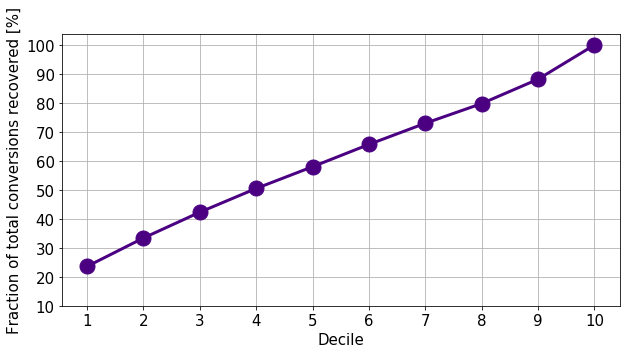

In [48]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(deciles, [round(x*100,1) for x in recalls], marker='o', c='Indigo', markersize=15, linewidth=3)
plt.xlabel('Decile', fontsize=15)
plt.ylabel('Fraction of total conversions recovered [%]', fontsize=15)
plt.xticks(np.arange(1, 10+1, 1), fontsize=15)
plt.yticks(np.arange(10, 100+1, 10), fontsize=15)
plt.grid()
plt.show()

# 2 times better than random 

In [49]:
recalls

[0.23638525564803806,
 0.3341260404280618,
 0.42306777645659926,
 0.5046373365041618,
 0.5803804994054697,
 0.6573127229488704,
 0.7298454221165279,
 0.7983353151010701,
 0.8815695600475624,
 1.0]